This notebook uses `astropy` and `reproject` to load a FITS image in galactic lat/lon and plots it then reprojects it into FK5 RA/Dec and plots the reprojected image. 

# Imports

In [1]:
import numpy as np
from astropy import units as u
from astropy.io import fits
from astropy.utils.data import cache_contents
from astropy.wcs import WCS
from astropy.wcs.utils import celestial_frame_to_wcs
from astropy.coordinates import FK5, SkyCoord
from reproject import reproject_interp

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

# Configuration

In [2]:
# URL of test data provided with astropy
URL = "http://data.astropy.org/galactic_center/gc_msx_e.fits"

# Load FITS image

In [3]:
with fits.open(URL) as hdu_list:
    image_in = hdu_list[0].data[()]
    wcs_in = WCS(hdu_list[0].header)
    header = hdu_list[0].header

# Set up new coordinate system

In [4]:
# Set up SkyCoord object for transforming the central
# image coordinates from galactic coordinates to the
# desired output system (in this case FK5)
image_center = SkyCoord(
    *wcs_in.wcs.crval,
    unit="deg",
    frame="galactic"
)

In [5]:
# Pad the output image a bit to account for the rotated edges
# of the input image in the output coordinate system
shape_out = (210, 210)

# Create a World Coordinate System object for the output
# projection in FK5 coordinates
wcs_out = celestial_frame_to_wcs(FK5(), projection="CAR")
# Specify the central reference pixels in the new image
# and assign the FK5 coordinates to the reference pixels
wcs_out.wcs.crpix = np.array([shape_out[0]/2, shape_out[1]/2])
wcs_out.wcs.crval = np.array([image_center.fk5.ra.deg, image_center.fk5.dec.deg])
wcs_out.wcs.cunit = ["deg", "deg"]
# Keep the pixel size the same in the reprojected image
wcs_out.wcs.cdelt = wcs_in.wcs.cdelt

# Reproject image

In [6]:
image_out, _ = reproject_interp(
    (image_in, wcs_in),
    wcs_out,
    shape_out=shape_out
)

# Plot image before and after reprojection

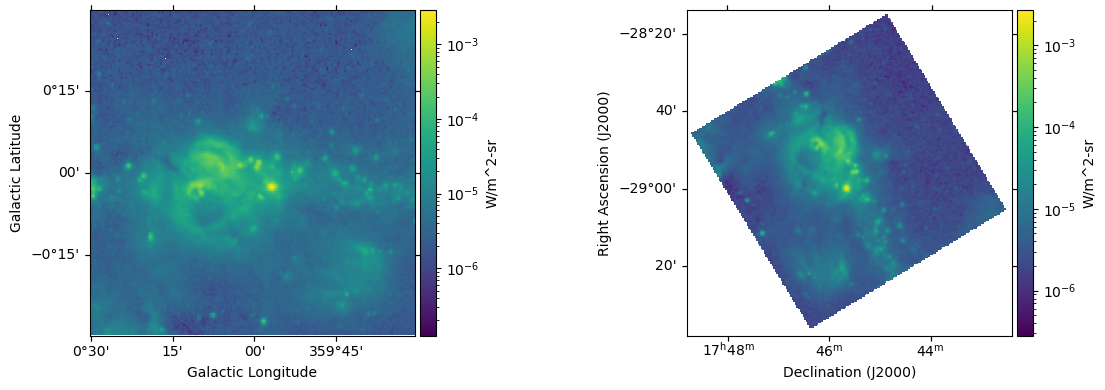

In [7]:
fig = plt.figure(figsize=(12, 4))
gs = fig.add_gridspec(1, 2, wspace=1)

ax = fig.add_subplot(gs[0], projection=wcs_in)
ax.set_ylabel("Galactic Latitude")
ax.set_xlabel("Galactic Longitude")
im = ax.imshow(image_in, norm=LogNorm(), origin="lower")
cb = fig.colorbar(im, ax=ax, pad=0.01, label=header["BUNIT"])

ax = fig.add_subplot(gs[1], projection=wcs_out)
ax.set_ylabel("Right Ascension (J2000)")
ax.set_xlabel("Declination (J2000)")
im = ax.imshow(image_out, norm=LogNorm(), origin="lower")
cb = fig.colorbar(im, ax=ax, pad=0.01, label=header["BUNIT"])

gs.tight_layout(fig);